### Bushfire Spectral Statistical Sampling
Created by Amos Bennett.<br>
Last Updated 23 Aug 20. <br>

__Updates:__ 

This script will be used to generate supporting research graphics for the dNBR script. It is important to note that the s2a/b_ard_granule NBART bands are surface reflectance measurements scaled by 10,000. Surface reflectance is the proportion of EM energy reflected from the target. The script currently loads a subset of the area of interest into an x-array datasets for the time-period Nov-19 to May 20 (fire event at Tumbarumba IVO 06-Jan-20). Using a random sample method, NIR, SWIR and NBR statistics are generated with support graphics and visualisations.

In [1]:
import sys
import datacube
from datacube.helpers import write_geotiff
from datetime import datetime
from datetime import timedelta
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/home/554/ab4513/dea-notebooks/Scripts")
import dea_datahandling
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_plotting import display_map
from dea_bandindices import calculate_indices

/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [2]:
print(datacube.__version__)

1.8.0


In [160]:
from matplotlib import rcParams
rcParams['axes.titlepad'] = 0

In [3]:
dc = datacube.Datacube(app="cube")

In [4]:
# Set the central latitude and longitude
central_lat = -35.783333
central_lon = 148.016667

# Canberra 148.6547665°E 35.5655761°S
# Kosciuszko 148.3517111°E 36.1864717°S
# Tumbarumba 148.016667°E 35.783333°S

# 0.1° approximately equal to 11.1km distance.

# Set the buffer to load around the central coordinates (even numbers such as 0.2, 1.0, 2.2 etc) in degrees (lat, lon)
buffer = 0.2

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

# display_map(x=study_area_lon, y=study_area_lat, margin=-0.2)

In [5]:
# Key Dates
prefire_start = '2019-11-01'
#prefire_end = '2020-02-19'
#postfire_start = '2020-02-28'
postfire_end = '2020-05-01'

In [6]:
fulldate_ard = load_ard(dc=dc,
               products=['s2a_ard_granule', 's2b_ard_granule'],
               x = (central_lon - buffer, central_lon + buffer),
               y = (central_lat - buffer, central_lat + buffer),
               time=(prefire_start, postfire_end),
               measurements=['nbart_nir_1',
                             'nbart_swir_3'],
               min_gooddata=0.2,
               output_crs='EPSG:32755', # UTM Zone 55S
               resolution=(-10,10),
               group_by='solar_day')

Loading s2a_ard_granule data
    Filtering to 24 out of 36 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 22 out of 35 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 46 observations 


In [7]:
fulldate_ard

<xarray.Dataset>
Dimensions:       (time: 46, x: 3662, y: 4475)
Coordinates:
    spatial_ref   int32 32755
  * y             (y) float64 6.062e+06 6.062e+06 ... 6.017e+06 6.017e+06
  * x             (x) float64 5.736e+05 5.736e+05 ... 6.102e+05 6.102e+05
  * time          (time) datetime64[ns] 2019-11-01T00:02:41.024000 ... 2020-04-27T00:11:09.024000
Data variables:
    nbart_nir_1   (time, y, x) float32 nan nan nan nan ... 1267.0 1302.0 1396.0
    nbart_swir_3  (time, y, x) float32 nan nan nan nan ... 879.0 802.0 802.0
Attributes:
    crs:           EPSG:32755
    grid_mapping:  spatial_ref

In [274]:
lon = np.random.randint(0,3662, size=1)
lon = lon[0]
lat = np.random.randint(0,4475, size=1)
lat = lat[0]

In [287]:
full_nir_df = fulldate_ard.nbart_nir_1[:,lon,lat].to_dataframe()
full_swir_df = fulldate_ard.nbart_swir_3[:,lon,lat].to_dataframe()

In [288]:
nbart_swir_3 = full_swir_df['nbart_swir_3']
fullfire = full_nir_df.join(nbart_swir_3).dropna()
fullfire['nbr'] = (fullfire.nbart_nir_1-fullfire.nbart_swir_3)/(fullfire.nbart_nir_1+fullfire.nbart_swir_3)
ycoord = np.int_(fullfire.y[0], decimals=0)
xcoord = np.int_(fullfire.x[0], decimals=0)
fullfire.head()

,spatial_ref,y,x,nbart_nir_1,nbart_swir_3,nbr
time,,,,,,
2019-11-01 00:02:41.024,32755,6046185.0,603855.0,1711.0,862.0,0.329965
2019-11-04 00:11:11.024,32755,6046185.0,603855.0,1941.0,719.0,0.459399
2019-11-11 00:02:41.024,32755,6046185.0,603855.0,1605.0,797.0,0.336386
2019-11-14 00:11:11.024,32755,6046185.0,603855.0,1700.0,633.0,0.457351
2019-11-16 00:02:39.024,32755,6046185.0,603855.0,1558.0,878.0,0.279146


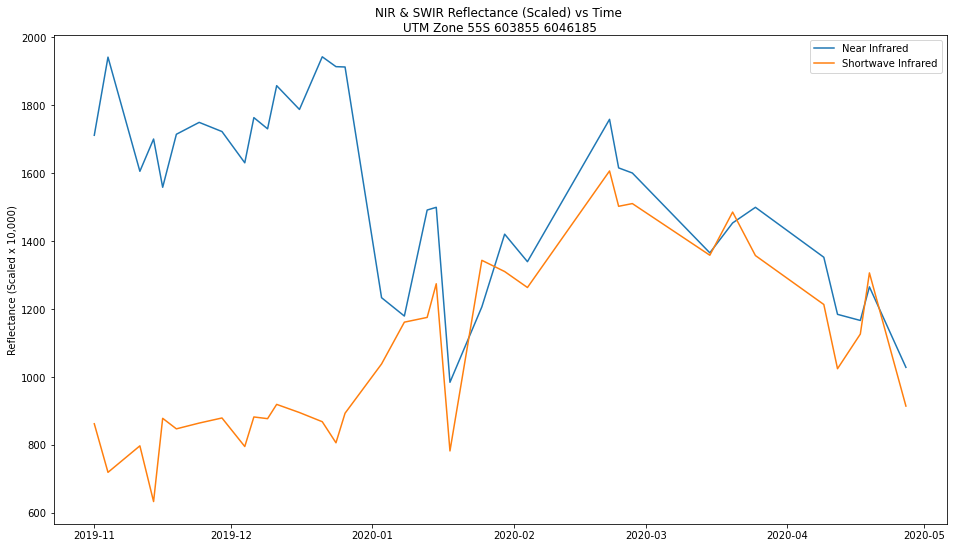

In [289]:
fig = plt.figure(figsize=(16,9))
ax = plt.axes()
x = fullfire.index
y1 = fullfire.nbart_nir_1
y2 = fullfire.nbart_swir_3
plt.plot(x, y1, label='Near Infrared')
plt.plot(x, y2, label='Shortwave Infrared')
name = 'NIR & SWIR Reflectance (Scaled) vs Time \n'
coordinate = 'UTM Zone 55S ' + str(xcoord) + ' ' + str(ycoord)
plt.title(name + coordinate)
plt.ylabel('Reflectance (Scaled x 10,000)')
plt.legend()

In [290]:
name = './supporting graphics/NIR_SWIR_Time_'+coordinate+'.png'
fig.savefig(name)

Where vegetation is healthy, the NIR (talking in reflectance) will be higher that the SWIR. In burnt vegetation, SWIR will be higher than the NIR...??? Large spikes in NIR and SWIR reflectance are probably indicative of fire activity (either bushfire or backburning).

I keep seeing a large spike in the NBR value around May 2020 as I randomly sample points. I suspect this is due to either the loss or changing of colour of leaves during the autumn period but I am yet to confirm this theory.

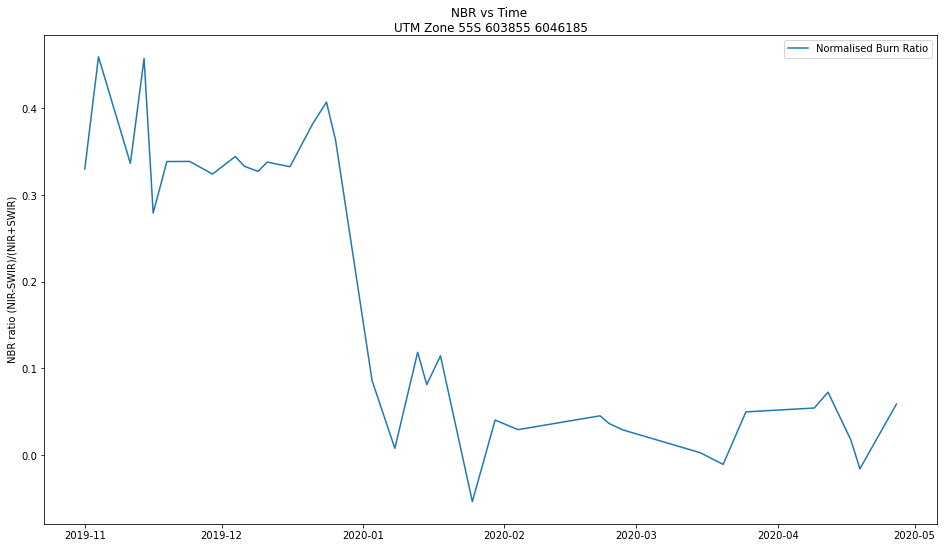

In [291]:
fig = plt.figure(figsize=(16,9))
ax = plt.axes()
x = fullfire.index
y = fullfire.nbr
plt.plot(x, y, label='Normalised Burn Ratio')
name = 'NBR vs Time \n'
coordinate = 'UTM Zone 55S ' + str(xcoord) + ' ' + str(ycoord)
plt.title(name + coordinate)
plt.ylabel('NBR ratio (NIR-SWIR)/(NIR+SWIR)')
plt.legend()

In [292]:
name = './supporting graphics/NBR_Time_'+coordinate+'.png'
fig.savefig(name)

A breakdown of the pre and postfire scene statistics is calculated showing the median NIR, median SWIR and median NBR values. Included is an NBR value calculated from the median NIR and SWIR values. The reason for this is double check there is not too much variance from the median NBR. This is because the method used in the script to generate the NBR geotiff images from the x-array datasets calculates one NBR value based on the median NIR and SWIR values resulting is less computation required. The median is used noting that based on the histograms below showing skewed data, the median is the most appropriate measure of central tendancy.

In [293]:
prefire = fullfire[:16] # Dataframe sliced up to fire-event date.
prefire

,spatial_ref,y,x,nbart_nir_1,nbart_swir_3,nbr
time,,,,,,
2019-11-01 00:02:41.024,32755,6046185.0,603855.0,1711.0,862.0,0.329965
2019-11-04 00:11:11.024,32755,6046185.0,603855.0,1941.0,719.0,0.459399
2019-11-11 00:02:41.024,32755,6046185.0,603855.0,1605.0,797.0,0.336386
2019-11-14 00:11:11.024,32755,6046185.0,603855.0,1700.0,633.0,0.457351
2019-11-16 00:02:39.024,32755,6046185.0,603855.0,1558.0,878.0,0.279146
2019-11-19 00:11:09.024,32755,6046185.0,603855.0,1714.0,847.0,0.338540
2019-11-24 00:11:11.024,32755,6046185.0,603855.0,1749.0,864.0,0.338691
2019-11-29 00:11:09.024,32755,6046185.0,603855.0,1722.0,879.0,0.324106
2019-12-04 00:11:11.024,32755,6046185.0,603855.0,1630.0,795.0,0.344330


In [294]:
nir_med = prefire.nbart_nir_1.median()
swir_med = prefire.nbart_swir_3.median()
nbr_med = prefire.nbr.median()
nbr_calc_med = (nir_med-swir_med)/(nir_med+swir_med)
print('Prefire Statistics:')
print('Median NIR pixel value: ' + str(nir_med))
print('Median SWIR pixel value: ' + str(swir_med))
print('Median NBR pixel value: ' + str(nbr_med))
print('NBR calculated from median NIR and SWIR: ' + str(nbr_calc_med))

name = './supporting graphics/prefirestats_'+coordinate+'.txt'
text_file = open(name, "w")
text_file.write('Prefire Statistics: \n'
                'Median NIR pixel value: ' + str(nir_med) + '\n'
                'Median SWIR pixel value: ' + str(swir_med) + '\n'
                'Median NBR pixel value: ' + str(nbr_med) + '\n'
                'NBR calculated from median NIR and SWIR: ' + str(nbr_calc_med))
text_file.close()

Prefire Statistics:
Median NIR pixel value: 1739.5
Median SWIR pixel value: 866.0
Median NBR pixel value: 0.33821794390678406
NBR calculated from median NIR and SWIR: 0.33525235079639226


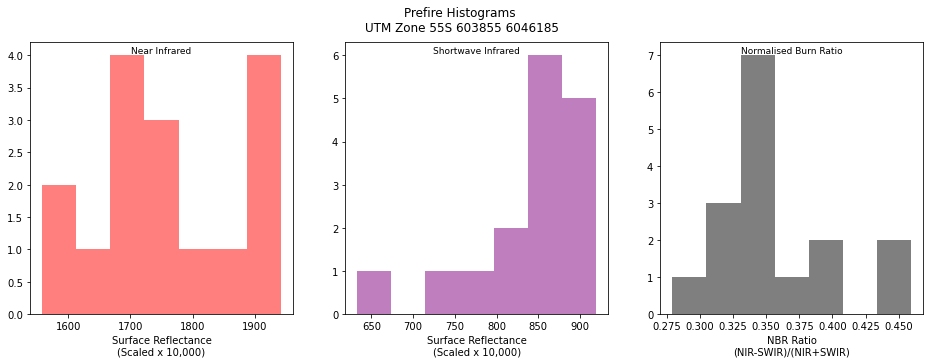

In [295]:
fs=9 #subplot fontsize
ydis=0.96 #subplot vertical displacement
b=7 #bins
a = 0.5 #transparency

name = 'Prefire Histograms \n'
coordinate = 'UTM Zone 55S ' + str(xcoord) + ' ' + str(ycoord)

fig, axs = plt.subplots(1, 3, figsize=(16, 5), sharey=False)
axs[0].hist(prefire.nbart_nir_1, bins=b, histtype='stepfilled', color='red', alpha=a)
axs[0].set_title('Near Infrared', y=ydis, fontsize=fs)
axs[0].set_xlabel('Surface Reflectance\n(Scaled x 10,000)')
axs[1].hist(prefire.nbart_swir_3, bins=b, histtype='stepfilled', color='purple', alpha=a)
axs[1].set_title('Shortwave Infrared', y=ydis, fontsize=fs)
axs[1].set_xlabel('Surface Reflectance\n(Scaled x 10,000)')
axs[2].hist(prefire.nbr, bins=b, histtype='stepfilled', color='black', alpha=a)
axs[2].set_title('Normalised Burn Ratio', y=ydis, fontsize=fs)
axs[2].set_xlabel('NBR Ratio\n(NIR-SWIR)/(NIR+SWIR)')
fig.suptitle(name + coordinate)

name = './supporting graphics/prefirehists_'+coordinate+'.png'
plt.savefig(name)

In [296]:
postfire = fullfire[17:40] # Dataframe sliced post fire-event date.
postfire

,spatial_ref,y,x,nbart_nir_1,nbart_swir_3,nbr
time,,,,,,
2020-01-08 00:11:09.024,32755,6046185.0,603855.0,1179.0,1161.0,0.007692
2020-01-13 00:11:01.024,32755,6046185.0,603855.0,1491.0,1175.0,0.118530
2020-01-15 00:02:39.024,32755,6046185.0,603855.0,1499.0,1274.0,0.081140
2020-01-18 00:11:09.024,32755,6046185.0,603855.0,984.0,782.0,0.114383
2020-01-25 00:02:39.024,32755,6046185.0,603855.0,1206.0,1343.0,-0.053747
2020-01-30 00:02:31.024,32755,6046185.0,603855.0,1420.0,1310.0,0.040293
2020-02-04 00:02:39.024,32755,6046185.0,603855.0,1339.0,1263.0,0.029208
2020-02-22 00:11:01.024,32755,6046185.0,603855.0,1758.0,1606.0,0.045184
2020-02-24 00:02:39.024,32755,6046185.0,603855.0,1615.0,1502.0,0.036253


In [297]:
nir_med = postfire.nbart_nir_1.median()
swir_med = postfire.nbart_swir_3.median()
nbr_med = postfire.nbr.median()
nbr_calc_med = (nir_med-swir_med)/(nir_med+swir_med)
print('Postfire Statistics:')
print('Median NIR pixel value: ' + str(nir_med))
print('Median SWIR pixel value: ' + str(swir_med))
print('Median NBR pixel value: ' + str(nbr_med))
print('NBR calculated from median NIR and SWIR: ' + str(nbr_calc_med))

name = './supporting graphics/postfirestats_'+coordinate+'.txt'
text_file = open(name, "w")
text_file.write('Postfire Statistics: \n'
                'Median NIR pixel value: ' + str(nir_med) + '\n'
                'Median SWIR pixel value: ' + str(swir_med) + '\n'
                'Median NBR pixel value: ' + str(nbr_med) + '\n'
                'NBR calculated from median NIR and SWIR: ' + str(nbr_calc_med))
text_file.close()

Postfire Statistics:
Median NIR pixel value: 1358.5
Median SWIR pixel value: 1290.0
Median NBR pixel value: 0.038272924721241
NBR calculated from median NIR and SWIR: 0.02586369643194261


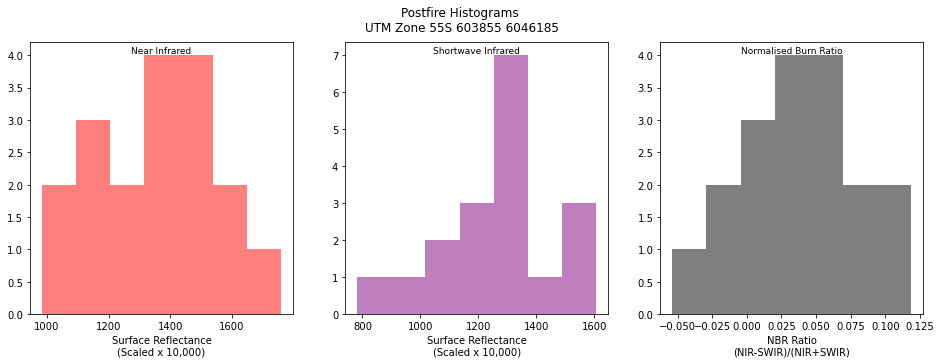

In [298]:
fs=9 #subplot fontsize
ydis=0.96 #subplot vertical displacement
b=7 #bins
a = 0.5 #transparency

name = 'Postfire Histograms \n'
coordinate = 'UTM Zone 55S ' + str(xcoord) + ' ' + str(ycoord)

fig, axs = plt.subplots(1, 3, figsize=(16, 5), sharey=False)
axs[0].hist(postfire.nbart_nir_1, bins=b, histtype='stepfilled', color='red', alpha=a)
axs[0].set_title('Near Infrared', y=ydis, fontsize=fs)
axs[0].set_xlabel('Surface Reflectance\n(Scaled x 10,000)')
axs[1].hist(postfire.nbart_swir_3, bins=b, histtype='stepfilled', color='purple', alpha=a)
axs[1].set_title('Shortwave Infrared', y=ydis, fontsize=fs)
axs[1].set_xlabel('Surface Reflectance\n(Scaled x 10,000)')
axs[2].hist(postfire.nbr, bins=b, histtype='stepfilled', color='black', alpha=a)
axs[2].set_title('Normalised Burn Ratio', y=ydis, fontsize=fs)
axs[2].set_xlabel('NBR Ratio\n(NIR-SWIR)/(NIR+SWIR)')
fig.suptitle(name + coordinate)

name = './supporting graphics/postfirehists_'+coordinate+'.png'
plt.savefig(name)